In [2]:
import pandas as pd
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
start_date = '2011-04-01'
end_date = '2011-12-09'
filtered_df = df[(df['InvoiceDate'] >= start_date) & (df['InvoiceDate'] <= end_date)]
filtered_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161.0,United Kingdom
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161.0,United Kingdom
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161.0,United Kingdom
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161.0,United Kingdom
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161.0,United Kingdom


In [8]:
import numpy as np
reference_date = pd.to_datetime('2011-12-09')
rfm_df = filtered_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days // 30,
    'InvoiceNo': 'count',
    'UnitPrice': lambda x: (x * filtered_df.loc[x.index, 'Quantity']).sum()
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'MonetaryValue'
})

print(rfm_df.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12347.0           0        122        3122.82
12348.0           2          8         677.00
12349.0           0         73        1757.55
12352.0           1         47         944.23
12353.0           6          4          89.00


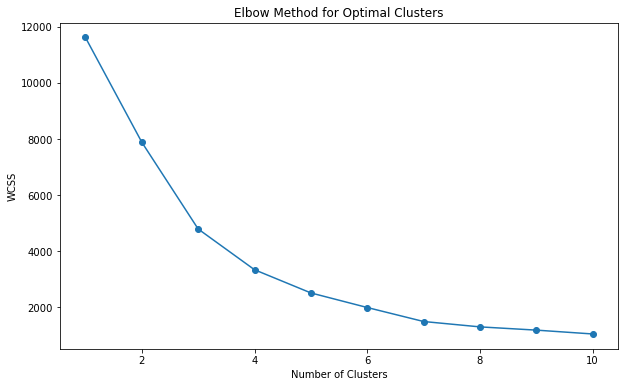

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
optimal_clusters = 4  

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm_df.head())

            Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
12347.0           0        122        3122.82        0
12348.0           2          8         677.00        0
12349.0           0         73        1757.55        0
12352.0           1         47         944.23        0
12353.0           6          4          89.00        1


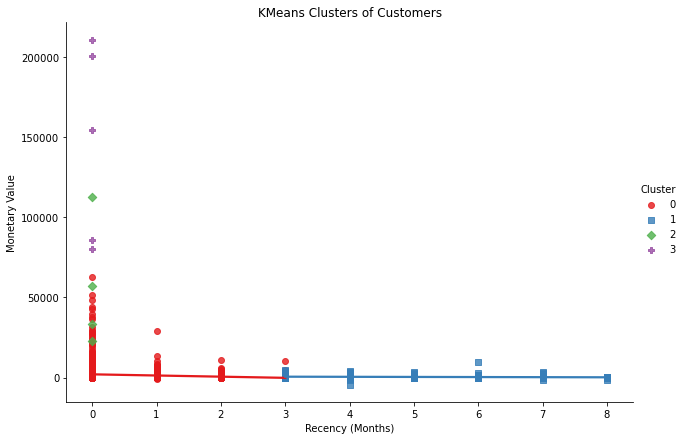

In [11]:
import seaborn as sns

# Add the RFM values to the DataFrame for plotting
rfm_df['Recency'] = rfm_df['Recency']
rfm_df['Frequency'] = rfm_df['Frequency']
rfm_df['MonetaryValue'] = rfm_df['MonetaryValue']

# Use lmplot to visualize clusters
sns.lmplot(data=rfm_df, x='Recency', y='MonetaryValue', hue='Cluster', palette='Set1', markers=["o", "s", "D", "P"], height=6, aspect=1.5)
plt.title('KMeans Clusters of Customers')
plt.xlabel('Recency (Months)')
plt.ylabel('Monetary Value')
plt.show()

In [12]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Recency', 'Frequency', 'MonetaryValue'])

print("Cluster Centers:")
print(cluster_centers_df)

Cluster Centers:
        Recency    Frequency  MonetaryValue
0  5.788931e-01    89.169130    1662.850431
1  4.995816e+00    26.713389     463.593746
2  0.000000e+00  5149.750000   56507.260000
3 -2.220446e-16   745.600000  146371.976000


In [13]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=optimal_clusters)
rfm_df['Agglo_Cluster'] = agglo.fit_predict(rfm_scaled)

print(rfm_df.head())

            Recency  Frequency  MonetaryValue  Cluster  Agglo_Cluster
CustomerID                                                           
12347.0           0        122        3122.82        0              0
12348.0           2          8         677.00        0              0
12349.0           0         73        1757.55        0              0
12352.0           1         47         944.23        0              0
12353.0           6          4          89.00        1              2


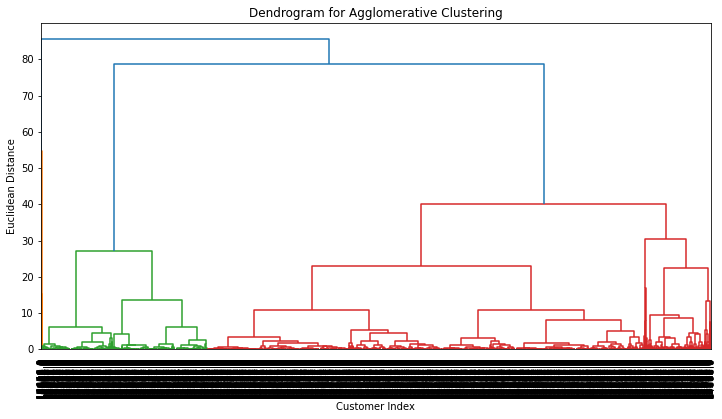

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(rfm_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=rfm_df.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Customer Index')
plt.ylabel('Euclidean Distance')
plt.show()

KMeans Cluster Summary:
           Recency    Frequency  MonetaryValue
Cluster                                      
0        0.579725    89.191753    1663.341152
1        4.997906    26.579058     460.842692
2        0.000000  5149.750000   56507.260000
3        0.000000   745.600000  146371.976000
Agglomerative Cluster Summary:
                 Recency    Frequency  MonetaryValue
Agglo_Cluster                                      
0              0.579670    89.480426    1715.139768
1              0.000000  5149.750000   56507.260000
2              4.996859    27.171728     473.759635
3              0.000000   714.333333  188453.316667


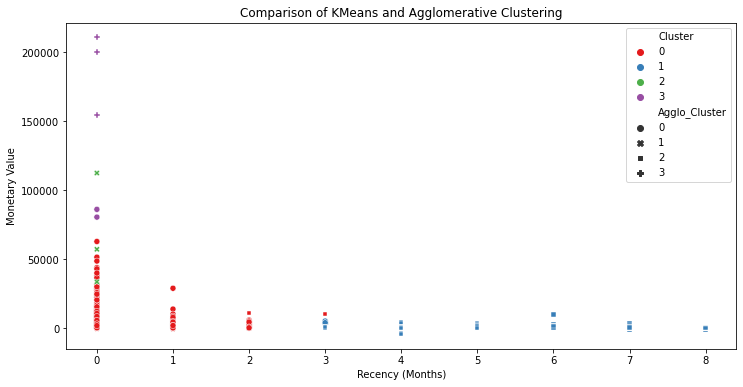

In [15]:
kmeans_summary = rfm_df.groupby('Cluster').mean()[['Recency', 'Frequency', 'MonetaryValue']]
print("KMeans Cluster Summary:\n", kmeans_summary)

agglo_summary = rfm_df.groupby('Agglo_Cluster').mean()[['Recency', 'Frequency', 'MonetaryValue']]
print("Agglomerative Cluster Summary:\n", agglo_summary)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='MonetaryValue', hue='Cluster', style='Agglo_Cluster', palette='Set1')
plt.title('Comparison of KMeans and Agglomerative Clustering')
plt.xlabel('Recency (Months)')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()